# **K2 algorithm** | implementation

Project for *Advanced Statistics for Physics Analysis*, University of Padua, A.Y. 2021/22<br>
**Learning the topology of a Bayesian Network from a database of cases using the K2 algorithm**

**Students** | Francesco Pio Barone, Gianmarco Nagaro Quiroz, Daniele Ninni

***
1) [**Introduction**](#sec1)
2) [**Implementation of the K2 algorithm in R**](#sec2)
    - 2.A [function $\texttt{k2}$](#sec2.A)
    - 2.B [function $\texttt{f}$](#sec2.B)
    - 2.C [function $\texttt{log.f}$](#sec2.C)
    - 2.D [function $\texttt{k2.iter}$](#sec2.D)
3) [**Test of the implementation**](#sec3)
    - 3.A [dummy dataset](#sec3.A)
    - 3.B [*ASIA* dataset](#sec3.B)
    - 3.C [*SACHS* dataset](#sec3.C)
    - 3.D [*CHILD* dataset](#sec3.D)
***

In [1]:
# load packages
library(tidyverse) |> suppressPackageStartupMessages()
library(bnlearn)   |> suppressPackageStartupMessages()
library(Rgraphviz) |> suppressPackageStartupMessages()

<a id='sec1'></a>
## **1** - Introduction

### Bayesian networks

A **Bayesian network** (also known as a **belief network**) is a probabilistic graphical model that represents a set of variables and their conditional dependencies via a directed acyclic graph (DAG).

Such DAGs consist of:

- $\color{red}{\text{nodes}}\leftrightarrow$ variables in the Bayesian sense (observable quantities, latent variables, unknown parameters or hypotheses)
    - unconnected nodes $\leftrightarrow$ conditionally independent variables
    - each node $\leftrightarrow$ probability function (INPUT: a particular set of values for the node's parent variables, OUTPUT: probability of the variable represented by the node)
- $\color{blue}{\text{edges}}\leftrightarrow$ conditional dependencies

Given a database of records, it is interesting to construct a Bayesian network which can provide insights into the probabilistic dependencies existing among the variables in the database itself.
Such network can be further used to predict the future behaviour of the system thus modeled.

### Topology learning

In the simplest case, a Bayesian network has a small number of nodes and therefore can be specified manually by an expert.
Even in the case of a large number of nodes, an expert could be able to assess the network structure, if his knowledge of the system is sufficient.
In general, it is crucial to learn the network topology following a data-driven approach.

Automatically learning the graph structure of a Bayesian network is a challenge pursued within machine learning.
For instance, $\color{green}{\text{score-based}}$ algorithms use optimization-based search according to:

- a scoring function
- a search strategy

Such score-based algorithms focus on the DAG as a whole and approach the topology learning task as an optimization problem:

1) each candidate DAG is assigned a score which represents a statistical measurement of how well the DAG itself mirrors the dependence structure of the data
2) the output DAG is the one corresponding to the highest score

### K2 algorithm

The K2 algorithm is a score-based algorithm introduced by G. F. Cooper and E. Herskovits in 1992.
It allows to learn the topology of a Bayesian network, i.e. to find the most probable belief network structure, given a database of cases.

The algorithm holds on the following assumptions:

- there is an ordering on the domain variables
- a priori, all structures are considered equally likely

The algorithm is based on the use of a greedy-search method. In particular, for each node:

1) it begins by making the assumption that the current node has no parents
2) it adds incrementally that parent whose addition most increases the probability of the resulting structure
3) when the addition of no single parent can increase the probability, it stops adding parents to the current node and moves on to the next node

<a id='sec2'></a>
## **2** - Implementation of the K2 algorithm in R

**INPUT**:

- a set of $n$ nodes
- an ordering on the nodes
- an upper bound $u$ on the number of parents a node may have
- a database $D$ containing $m$ cases

**OUTPUT**:

- for each node, a printout of the parents of the node

**PSEUDOCODE**:

```
for i := 1 to n do

    π_i     := ∅
    P_old   := f(i, π_i)
    proceed := true

    while proceed and |π_i| < u do

        z     := node in Pred(x_i) - π_i that maximizes f(i, π_i ∪ {z})
        P_new := f(i, π_i ∪ {z})

        if P_new > P_old then

            P_old := P_new
            π_i   := π_i ∪ {z}

        else proceed := false

    end {while}

    write('Node:', x_i, 'Parents of this node:', π_i)
    
end {for}
```

<a id='sec2.A'></a>
### **2.A** function $\texttt{k2}$

In [2]:
k2 <- function(dataset, parents.nmax, f, ...) {

        nodes   <- names(dataset)           # node names
        net.dag <- empty.graph(nodes=nodes) # network DAG (Directed Acyclic Graph)

        for (i in 2:length(nodes)) {

            node           <- nodes[i]                  # current node
            previous.nodes <- nodes[1:(i-1)]            # nodes that precede the current node
            parents        <- c()                       # parents of the current node
            P_old          <- f(node, parents, dataset) # old probability
            proceed        <- T
            
            while (proceed & (length(parents) < parents.nmax)) {

                candidates <- setdiff(previous.nodes, parents) # candidate parents of the current node 
                P_new      <- P_old                            # new probability

                for (candidate in candidates) {

                    candidate.score <- f(node, c(parents, candidate), dataset) # candidate parent score

                    if (candidate.score > P_new) {

                        candidates.best <- candidate       # best candidate parent
                        P_new           <- candidate.score

                    }

                }

                if (P_new > P_old) {

                    P_old   <- P_new
                    parents <- c(parents, candidates.best)
                    net.dag <- set.arc(net.dag, from=candidates.best, to=node)

                } else {

                    proceed <- F

                }

            }

        }

        net.score <- score(net.dag, dataset |> mutate_all(as_factor) |> as.data.frame(), ...) # network score

        return(list('dag'=net.dag, 'score'=net.score))

}

<a id='sec2.B'></a>
### **2.B** function $\texttt{f}$

The scoring function $f(i, \pi_i)$ is the probability of the database $D$ given that the set of parents of the variable $x_i$ is represented by the list of variables $\pi_i$.

$$
f(i, \pi_i) = \prod_{j=1}^{q_i} \frac{(r_i - 1)! \prod_{k=1}^{r_i} \alpha_{ijk}!}{(N_{ij} + r_i - 1)!} = \prod_{j=1}^{q_i} f_j
$$

where:

- $V_i =$ list of unique instantiations of $x_i$ relative to $D$
- $r_i = |V_i|$
- $\phi_i =$ list of unique instantiations of $\pi_i$ relative to $D$
- $q_i = |\phi_i|$
- $\alpha_{ijk} =$ # cases in $D$ in which $x_i$ is instantiated as the $k$-th element in $V_i$ and $\pi_i$ is instantiated as the $j$-th element in $\phi_i$
- $N_{ij} = \sum_{k=1}^{r_i} \alpha_{ijk} =$ # cases in $D$ in which $\pi_i$ is instantiated as the $j$-th element in $\phi_i$

In [3]:
f <- function(node, parents, dataset) {

    node.nunique <- dataset[node] |>
                        unique() |>
                        nrow()

    contingency_table <- dataset[c(node, parents)] |>
                            table() |>
                            as.data.frame() |>
                            as_tibble() |>
                            filter(Freq > 0)

    numerator <- contingency_table |>
                    mutate(Freq = factorial(Freq)) |>
                    group_by_at(parents) |>
                    summarise(Freq = prod(Freq), .groups='drop_last') |>
                    mutate(Freq = (Freq * factorial(node.nunique - 1))) |>
                    ungroup() |>
                    select(Freq) |>
                    deframe()

    denominator <- contingency_table |>
                    group_by_at(parents) |>
                    summarise(Freq = sum(Freq), .groups='drop_last') |>
                    mutate(Freq = factorial(Freq + node.nunique - 1)) |>
                    ungroup() |>
                    select(Freq) |>
                    deframe()

    dataset.prob <- prod(numerator / denominator)

    return(dataset.prob)

}

<a id='sec2.C'></a>
### **2.C** function $\texttt{log.f}$

It is possible to improve the run-time speed of the K2 algorithm by replacing $f$ with $\log(f)$.
In fact, the logarithmic version of the scoring function requires only addition and subtraction, rather than multiplication and division.

Note that:

$$
\log(n!) = \log \left( \prod_{x=1}^n x \right) = \sum_{x=1}^n \log(x)
$$

Therefore:

$$
\log(f) = \log \left( \prod_{j=1}^{q_i} f_j \right) = \sum_{j=1}^{q_i} \log(f_j)
$$

where:

$$
\begin{aligned}
\log(f_j) &= \log \left[ \frac{(r_i - 1)! \prod_{k=1}^{r_i} \alpha_{ijk}!}{(N_{ij} + r_i - 1)!} \right] = \newline
&= \log \left[ \left( r_i - 1 \right)! \right] + \log \left[ \prod_{k=1}^{r_i} \alpha_{ijk}! \right] - \log \left[ \left( N_{ij} + r_i - 1 \right)! \right] = \newline
&= \color{red}{\sum_{x=1}^{r_i - 1} \log(x)} + \color{green}{\sum_{k=1}^{r_i} \sum_{y=1}^{\alpha_{ijk}} \log(y)} - \color{blue}{\sum_{z=1}^{N_{ij} + r_i - 1} \log(z)} = \newline
&= \color{red}{A} + \color{green}{B} - \color{blue}{C}
\end{aligned}
$$

The use of $\log(f)$ as scoring function is particularly effective in the case of very large datasets, since it allows to avoid the computation of huge factorials.

In [4]:
log.f <- function(node, parents, dataset) {

    node.nunique <- dataset[node] |>
                        unique() |>
                        nrow()

    contingency_table <- dataset[c(node, parents)] |>
                            table() |>
                            as.data.frame() |>
                            as_tibble() |>
                            filter(Freq > 0)

    A <- 1:(node.nunique - 1) |>
            log() |>
            sum()

    B <- contingency_table |>
            rowwise() |>
            mutate(Freq = ((1:Freq) |> log() |> sum())) |>
            ungroup() |>
            group_by_at(parents) |>
            summarise(Freq = sum(Freq), .groups='drop_last') |>
            ungroup() |>
            select(Freq) |>
            deframe()

    C <- contingency_table |>
            group_by_at(parents) |>
            summarise(Freq = sum(Freq), .groups='drop_last') |>
            ungroup() |>
            rowwise() |>
            mutate(Freq = ((1:(Freq + node.nunique - 1)) |> log() |> sum())) |>
            ungroup() |>
            select(Freq) |>
            deframe()

    dataset.log.prob <- sum(A + B - C)
    
    return(dataset.log.prob)

}

<a id='sec2.D'></a>
### **2.D** function $\texttt{k2.iter}$

The K2 algorithm requires the knowledge of the true node ordering.
However, there are several cases in which such information is not known a priori.

In these cases, a possible solution is to use the K2 algorithm iteratively, following a *brute-force* approach.
In other words, we could perform an $\color{red}{\text{exhaustive}}$ search, i.e. we could test all the possible node orderings and then keep the one that leads to the highest score.

The main disadvantage of exhaustive search is that it increases the computation time by a factor $n!$, where $n$ is the number of nodes.
Therefore, in order to deal with a large number of nodes, a different approach is needed.

To mitigate this problem, we propose a $\color{green}{\text{randomized}}$ version of the K2 algorithm.
In particular:

1) instead of testing all the possible node orderings, the number of iterations to perform `n.iter` is fixed a priori
2) for each iteration, a random node ordering is sampled and then the corresponding optimal DAG is found
3) among all the `n.iter` DAGs found, the one that achieves the highest score is returned as output

In [5]:
k2.iter <- function(dataset, parents.nmax, f, k2, n.iter=1, seed=1, ...) {

    tic <- Sys.time()
    set.seed(seed)

    n.iter     <- max(n.iter, 1)
    best.score <- -Inf

    for (i in 1:n.iter) {

        cat('Running iteration #', i, '...')
        flush.console()

        nodes.order <- if (i == 1) names(dataset) else sample(names(dataset))
        result      <- k2(dataset[nodes.order], parents.nmax, f, ...)

        if (result$score > best.score) {

            best.dag   <- result$dag
            best.score <- result$score
            best.order <- nodes.order

        }

        cat(' DONE\n')
        flush.console()

    }

    toc <- Sys.time()
    cat('\nTotal execution time:', difftime(toc, tic, units='secs'), 's')

    return(list('dag'=best.dag, 'score'=best.score, 'order'=best.order))

}

<a id='sec3'></a>
## **3** - Test of the implementation

<a id='sec3.A'></a>
### **3.A** dummy dataset [[2]](#ref2)

In [6]:
dummy <- tibble(
            x1 = c(1, 1, 0, 1, 0, 0, 1, 0, 1, 0),
            x2 = c(0, 1, 0, 1, 0, 1, 1, 0, 1, 0),
            x3 = c(0, 1, 1, 1, 0, 1, 1, 0, 1, 0))

dummy

x1,x2,x3
<dbl>,<dbl>,<dbl>
1,0,0
1,1,1
0,0,1
1,1,1
0,0,0
0,1,1
1,1,1
0,0,0
1,1,1


Running iteration # 1 ... DONE

Total execution time: 0.2824841 s


  Random/Generated Bayesian network

  model:
   [x1][x2|x1][x3|x2] 
  nodes:                                 3 
  arcs:                                  2 
    undirected arcs:                     0 
    directed arcs:                       2 
  average markov blanket size:           1.33 
  average neighbourhood size:            1.33 
  average branching factor:              0.67 

  generation algorithm:                  Empty 


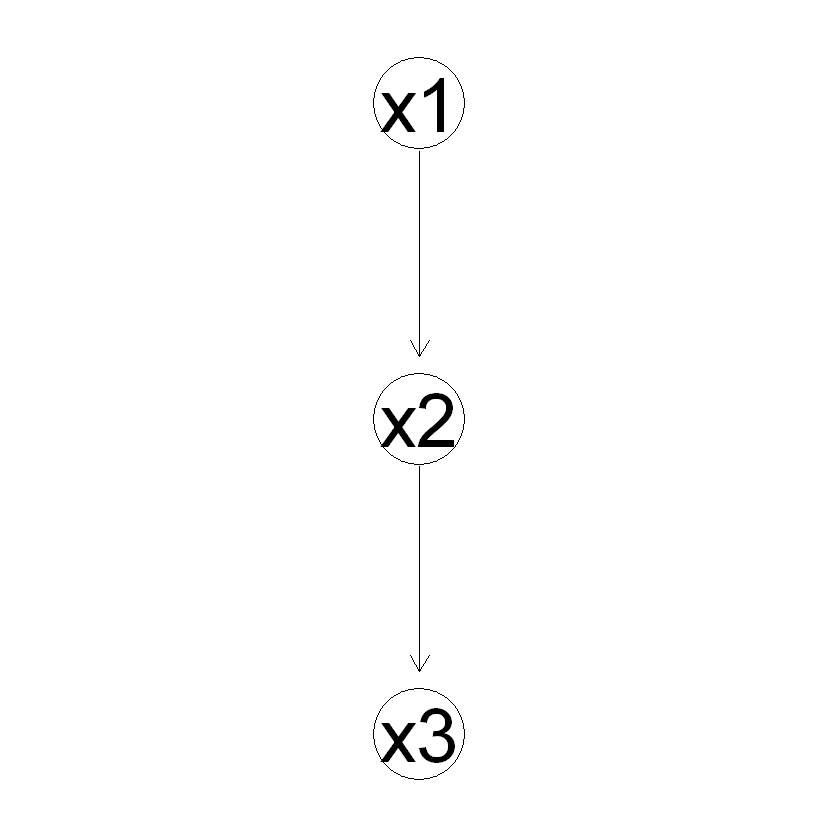

In [7]:
dummy_net <- k2.iter(dataset=dummy, parents.nmax=2, f=f, k2=k2, n.iter=1, seed=1, type='bic')

dummy_net$dag
graphviz.plot(dummy_net$dag)

Running iteration # 1 ... DONE

Total execution time: 0.2401311 s


  Random/Generated Bayesian network

  model:
   [x1][x2|x1][x3|x2] 
  nodes:                                 3 
  arcs:                                  2 
    undirected arcs:                     0 
    directed arcs:                       2 
  average markov blanket size:           1.33 
  average neighbourhood size:            1.33 
  average branching factor:              0.67 

  generation algorithm:                  Empty 


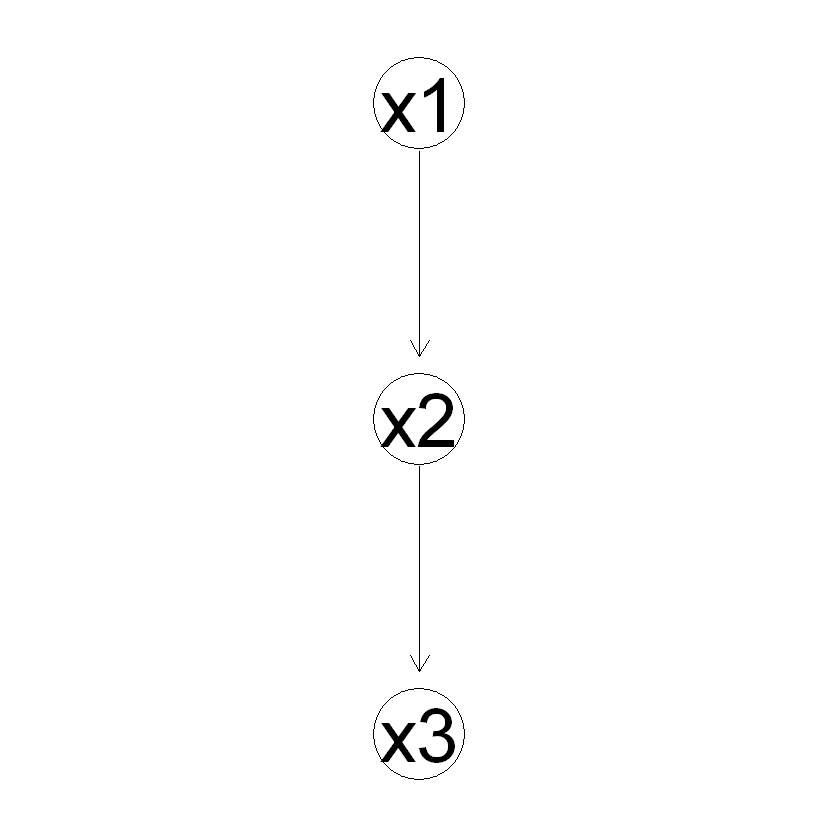

In [8]:
dummy_net <- k2.iter(dataset=dummy, parents.nmax=2, f=log.f, k2=k2, n.iter=1, seed=1, type='bic')

dummy_net$dag
graphviz.plot(dummy_net$dag)

<a id='sec3.B'></a>
### **3.B** *ASIA* dataset

In [9]:
asia <- read_csv('https://www.ccd.pitt.edu/wiki/images/ASIA10k.csv')

head(asia)

Rows: 10000 Columns: 8
-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: ","
chr (8): asia, tub, smoke, lung, bronc, either, xray, dysp

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


asia,tub,smoke,lung,bronc,either,xray,dysp
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
no,no,no,no,no,no,no,yes
no,no,yes,no,no,no,no,no
no,no,no,no,no,no,no,no
no,no,yes,no,no,no,no,no
no,no,yes,no,yes,no,no,yes
no,no,yes,no,no,no,no,no


Running iteration # 1 ... DONE
Running iteration # 2 ... DONE
Running iteration # 3 ... DONE
Running iteration # 4 ... DONE
Running iteration # 5 ... DONE

Total execution time: 11.18496 s

Best node ordering found: either tub asia bronc dysp lung smoke xray


  Random/Generated Bayesian network

  model:
   [either][tub|either][xray|either][asia|tub][lung|either:tub][bronc|asia]
   [dysp|either:bronc][smoke|either:bronc]
  nodes:                                 8 
  arcs:                                  10 
    undirected arcs:                     0 
    directed arcs:                       10 
  average markov blanket size:           2.75 
  average neighbourhood size:            2.50 
  average branching factor:              1.25 

  generation algorithm:                  Empty 


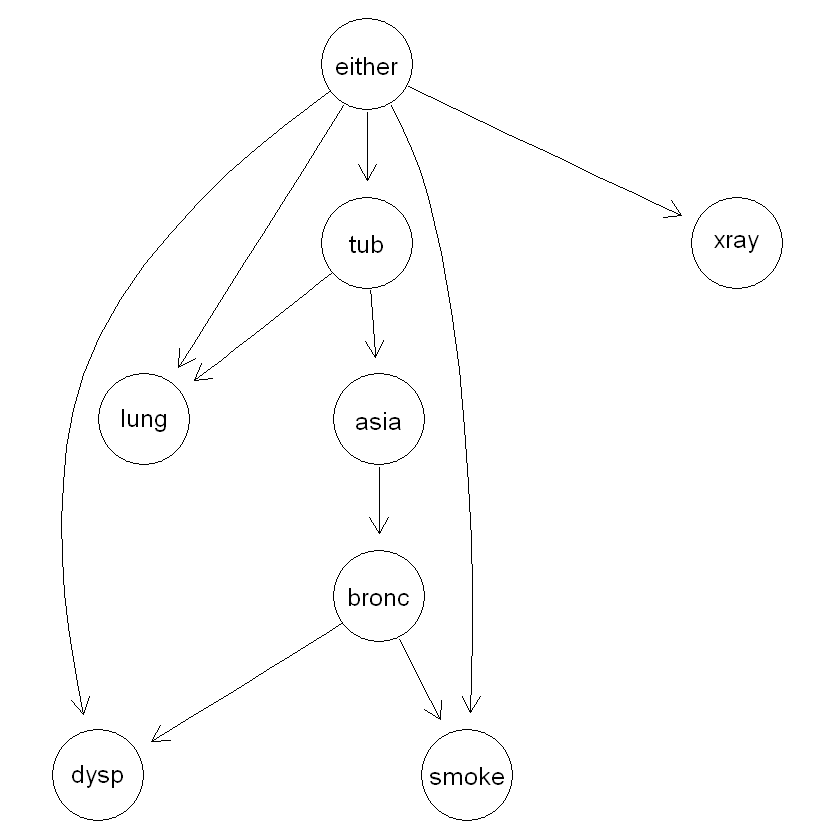

In [10]:
asia_net <- k2.iter(dataset=head(asia, 150), parents.nmax=2, f=f, k2=k2, n.iter=5, seed=1, type='bde', iss=10)

cat('\n\nBest node ordering found:', asia_net$order)
asia_net$dag
graphviz.plot(asia_net$dag)

Running iteration # 1 ... DONE
Running iteration # 2 ... DONE
Running iteration # 3 ... DONE
Running iteration # 4 ... DONE
Running iteration # 5 ... DONE

Total execution time: 11.2983 s

Best node ordering found: asia tub smoke lung bronc either xray dysp


  Random/Generated Bayesian network

  model:
   [asia][tub][smoke][lung|smoke][bronc|smoke][either|tub:lung][xray|either]
   [dysp|bronc:either]
  nodes:                                 8 
  arcs:                                  7 
    undirected arcs:                     0 
    directed arcs:                       7 
  average markov blanket size:           2.25 
  average neighbourhood size:            1.75 
  average branching factor:              0.88 

  generation algorithm:                  Empty 


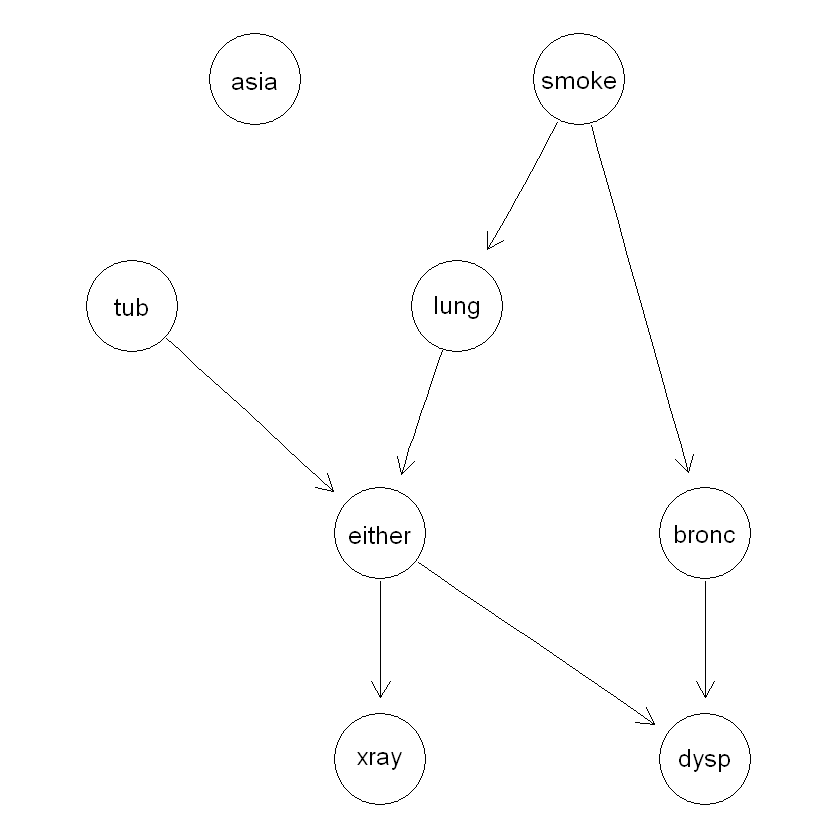

In [11]:
asia_net <- k2.iter(dataset=asia, parents.nmax=2, f=log.f, k2=k2, n.iter=5, seed=1, type='bde', iss=10)

cat('\n\nBest node ordering found:', asia_net$order)
asia_net$dag
graphviz.plot(asia_net$dag)

<a id='sec3.C'></a>
### **3.C** *SACHS* dataset

In [12]:
sachs <- read_csv('https://www.ccd.pitt.edu/wiki/images/SACHS10k.csv')
sachs <- sachs |> select(PKC, Plcg, PKA, PIP3, Raf, Jnk, P38, PIP2, Mek, Erk, Akt)

head(sachs)

Rows: 10000 Columns: 11
-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: ","
dbl (11): Akt, Erk, Jnk, Mek, P38, PIP2, PIP3, PKA, PKC, Plcg, Raf

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


PKC,Plcg,PKA,PIP3,Raf,Jnk,P38,PIP2,Mek,Erk,Akt
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,1,2,2,1,1,1,1,1,1,1
2,1,2,2,1,1,2,1,1,2,1
1,3,1,2,3,3,3,2,1,1,1
1,1,3,3,2,1,1,1,1,2,1
2,2,2,3,1,1,1,1,1,2,1
2,1,2,1,2,2,1,1,2,2,1


Running iteration # 1 ... DONE
Running iteration # 2 ... DONE
Running iteration # 3 ... DONE
Running iteration # 4 ... DONE
Running iteration # 5 ... DONE

Total execution time: 26.78662 s

Best node ordering found: PKC Plcg PKA PIP3 Raf Jnk P38 PIP2 Mek Erk Akt


  Random/Generated Bayesian network

  model:
   [PKC][Plcg][PKA|PKC][PIP3|Plcg][PIP2|Plcg][Raf|PKC:PKA][Jnk|PKC:PKA][P38|PKA]
   [Mek|PKA:Raf][Erk|PKA:Mek][Akt|PKA:Erk]
  nodes:                                 11 
  arcs:                                  14 
    undirected arcs:                     0 
    directed arcs:                       14 
  average markov blanket size:           2.55 
  average neighbourhood size:            2.55 
  average branching factor:              1.27 

  generation algorithm:                  Empty 


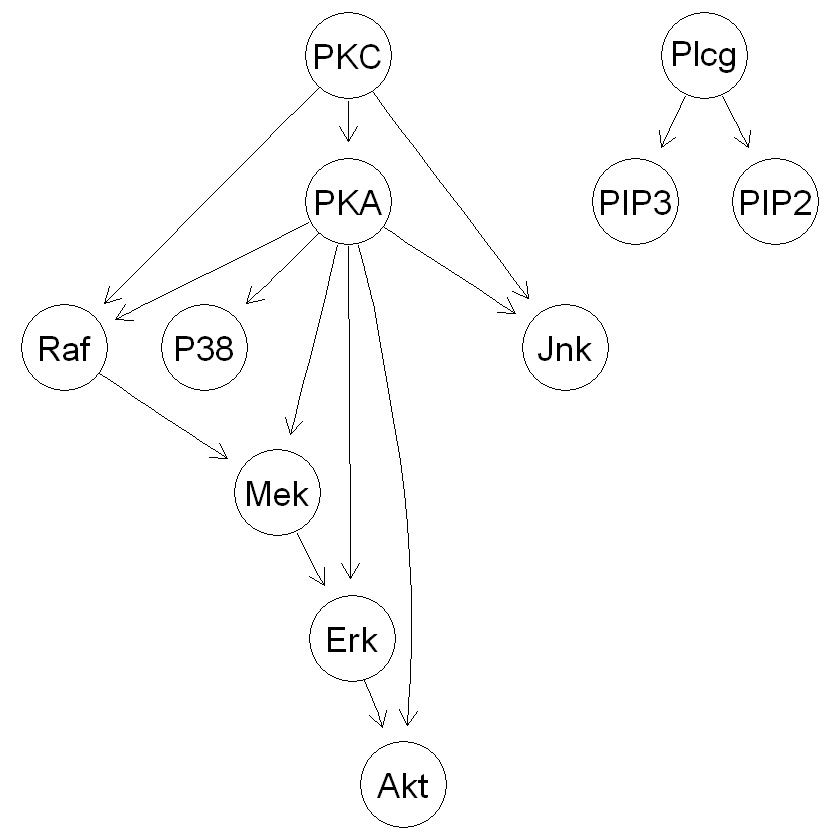

In [13]:
sachs_net <- k2.iter(dataset=head(sachs, 150), parents.nmax=3, f=f, k2=k2, n.iter=5, seed=1, type='bde', iss=10)

cat('\n\nBest node ordering found:', sachs_net$order)
sachs_net$dag
graphviz.plot(sachs_net$dag)

Running iteration # 1 ... DONE
Running iteration # 2 ... DONE
Running iteration # 3 ... DONE
Running iteration # 4 ... DONE
Running iteration # 5 ... DONE

Total execution time: 49.16842 s

Best node ordering found: PKC Plcg PKA PIP3 Raf Jnk P38 PIP2 Mek Erk Akt


  Random/Generated Bayesian network

  model:
   [PKC][Plcg][PKA|PKC][PIP3|Plcg][Raf|PKC:PKA][Jnk|PKC:PKA][P38|PKC:PKA]
   [PIP2|Plcg:PIP3][Mek|PKC:PKA:Raf][Erk|PKA:Mek][Akt|PKA:Erk]
  nodes:                                 11 
  arcs:                                  17 
    undirected arcs:                     0 
    directed arcs:                       17 
  average markov blanket size:           3.09 
  average neighbourhood size:            3.09 
  average branching factor:              1.55 

  generation algorithm:                  Empty 


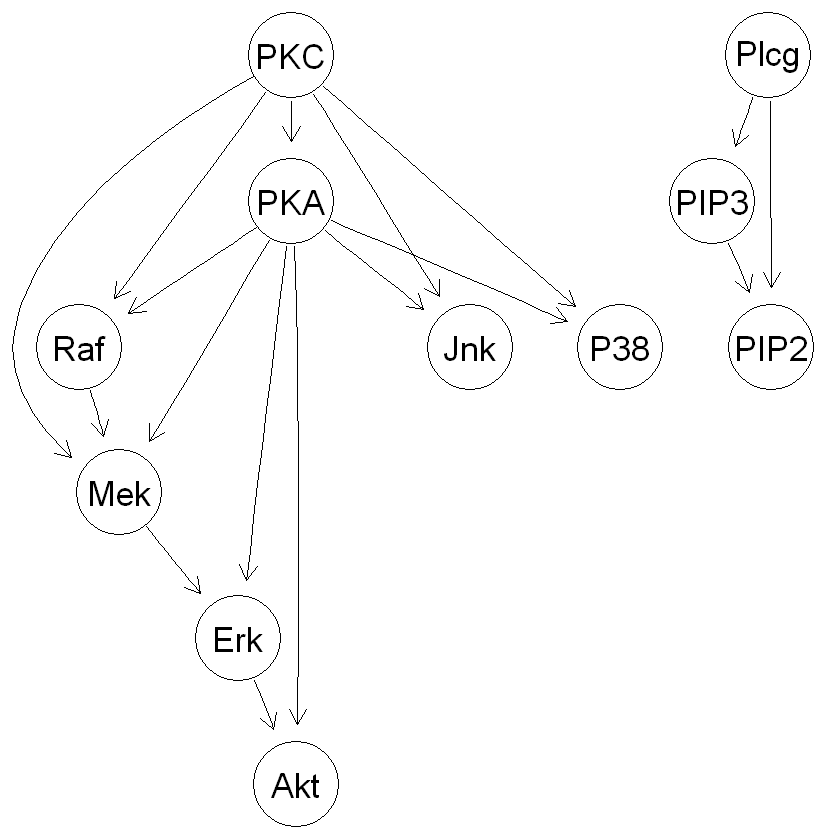

In [14]:
sachs_net <- k2.iter(dataset=sachs, parents.nmax=3, f=log.f, k2=k2, n.iter=5, seed=1, type='bde', iss=10)

cat('\n\nBest node ordering found:', sachs_net$order)
sachs_net$dag
graphviz.plot(sachs_net$dag)

<a id='sec3.D'></a>
### **3.D** *CHILD* dataset

In [15]:
child <- read_csv('https://www.ccd.pitt.edu/wiki/images/CHILD10k.csv')
child <- child |> select(BirthAsphyxia, Disease, Sick, DuctFlow, CardiacMixing, LungParench, LungFlow, LVH, Age, Grunting, HypDistrib, HypoxiaInO2, CO2, ChestXray, LVHreport, GruntingReport, LowerBodyO2, RUQO2, CO2Report, XrayReport)

head(child)

Rows: 10000 Columns: 20
-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: ","
chr (20): BirthAsphyxia, HypDistrib, HypoxiaInO2, CO2, ChestXray, Grunting, ...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


BirthAsphyxia,Disease,Sick,DuctFlow,CardiacMixing,LungParench,LungFlow,LVH,Age,Grunting,HypDistrib,HypoxiaInO2,CO2,ChestXray,LVHreport,GruntingReport,LowerBodyO2,RUQO2,CO2Report,XrayReport
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
no,PAIVS,yes,Lt_to_Rt,Complete,Normal,Low,no,0-3_days,no,Equal,Moderate,Normal,Oligaemic,no,no,5-12,5-12,>=7.5,Grd_Glass
no,TGA,yes,None,Transp.,Abnormal,Low,no,0-3_days,yes,Equal,Severe,Normal,Asy/Patch,no,no,12+,<5,<7.5,Asy/Patchy
no,TGA,yes,None,Transp.,Normal,High,yes,0-3_days,no,Equal,Severe,Normal,Normal,yes,no,12+,5-12,<7.5,Normal
no,Lung,yes,None,Mild,Abnormal,Normal,no,0-3_days,yes,Equal,Moderate,Normal,Asy/Patch,no,yes,5-12,5-12,>=7.5,Asy/Patchy
no,Fallot,no,Lt_to_Rt,Complete,Normal,Low,no,4-10_days,no,Equal,Moderate,Normal,Normal,no,no,5-12,5-12,<7.5,Normal
no,Fallot,no,Lt_to_Rt,Mild,Normal,Low,no,4-10_days,no,Equal,Moderate,Normal,Oligaemic,no,yes,5-12,<5,<7.5,Oligaemic


Running iteration # 1 ... DONE
Running iteration # 2 ... DONE
Running iteration # 3 ... DONE
Running iteration # 4 ... DONE
Running iteration # 5 ... DONE

Total execution time: 70.8791 s

Best node ordering found: BirthAsphyxia Disease Sick DuctFlow CardiacMixing LungParench LungFlow LVH Age Grunting HypDistrib HypoxiaInO2 CO2 ChestXray LVHreport GruntingReport LowerBodyO2 RUQO2 CO2Report XrayReport


  Random/Generated Bayesian network

  model:
   [BirthAsphyxia][Disease][Sick|Disease][DuctFlow|Disease]
   [CardiacMixing|Disease][LungParench|Disease][LungFlow|Disease][LVH|Disease]
   [Age|Disease][Grunting|Sick:LungParench][HypDistrib|DuctFlow]
   [HypoxiaInO2|CardiacMixing][CO2|LungParench][ChestXray|LungParench:LungFlow]
   [LVHreport|LVH][GruntingReport|Grunting][LowerBodyO2|HypoxiaInO2]
   [RUQO2|HypoxiaInO2][CO2Report|CO2][XrayReport|ChestXray]
  nodes:                                 20 
  arcs:                                  20 
    undirected arcs:                     0 
    directed arcs:                       20 
  average markov blanket size:           2.20 
  average neighbourhood size:            2.00 
  average branching factor:              1.00 

  generation algorithm:                  Empty 


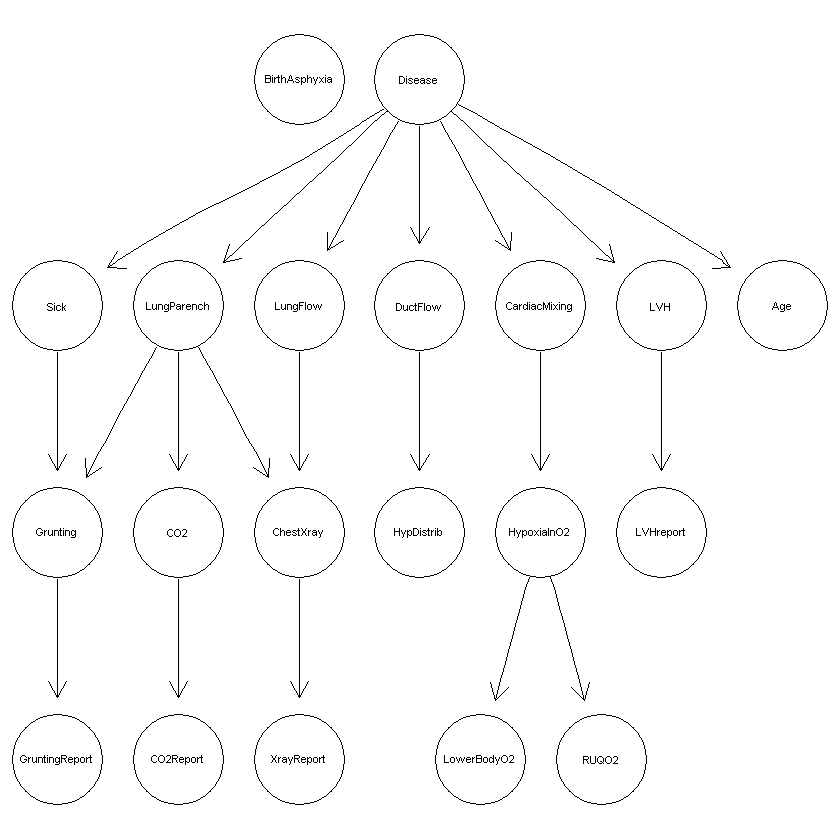

In [16]:
child_net <- k2.iter(dataset=head(child, 150), parents.nmax=2, f=f, k2=k2, n.iter=5, seed=1, type='bde', iss=10)

cat('\n\nBest node ordering found:', child_net$order)
child_net$dag
graphviz.plot(child_net$dag)

Running iteration # 1 ... DONE
Running iteration # 2 ... DONE
Running iteration # 3 ... DONE
Running iteration # 4 ... DONE
Running iteration # 5 ... DONE

Total execution time: 78.97155 s

Best node ordering found: BirthAsphyxia Disease Sick DuctFlow CardiacMixing LungParench LungFlow LVH Age Grunting HypDistrib HypoxiaInO2 CO2 ChestXray LVHreport GruntingReport LowerBodyO2 RUQO2 CO2Report XrayReport


  Random/Generated Bayesian network

  model:
   [BirthAsphyxia][Disease|BirthAsphyxia][Sick|Disease][DuctFlow|Disease]
   [CardiacMixing|Disease][LungParench|Disease][LungFlow|Disease][LVH|Disease]
   [Age|Disease:Sick][Grunting|Sick:LungParench]
   [HypDistrib|DuctFlow:CardiacMixing][HypoxiaInO2|CardiacMixing:LungParench]
   [CO2|LungParench][ChestXray|LungParench:LungFlow][LVHreport|LVH]
   [GruntingReport|Grunting][LowerBodyO2|HypDistrib:HypoxiaInO2]
   [RUQO2|HypoxiaInO2][CO2Report|CO2][XrayReport|ChestXray]
  nodes:                                 20 
  arcs:                                  25 
    undirected arcs:                     0 
    directed arcs:                       25 
  average markov blanket size:           3.00 
  average neighbourhood size:            2.50 
  average branching factor:              1.25 

  generation algorithm:                  Empty 


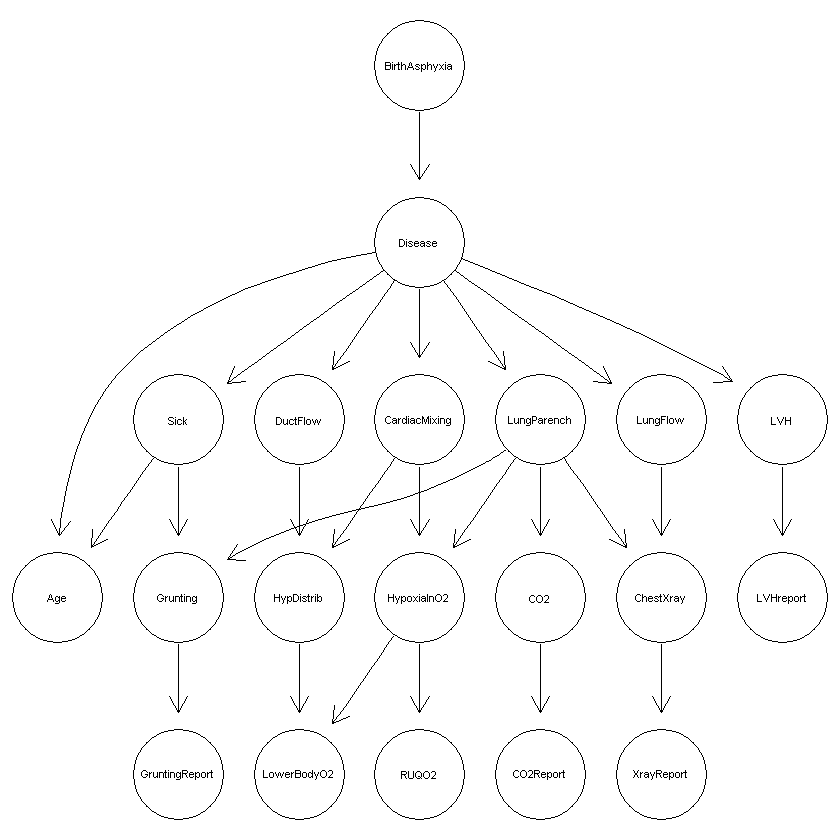

In [17]:
child_net <- k2.iter(dataset=child, parents.nmax=2, f=log.f, k2=k2, n.iter=5, seed=1, type='bde', iss=10)

cat('\n\nBest node ordering found:', child_net$order)
child_net$dag
graphviz.plot(child_net$dag)

## **References**

<a id='ref1'></a>
**[1]** M. Scutari and J. B. Denis, *Bayesian Networks*, CRC Press, 2022, Taylor and Francis Group

<a id='ref2'></a>
**[2]** G. F. Cooper and E. Herskovits, *A Bayesian Method for the Induction of Probabilistic Networks from Data*, Machine Learning 9, (1992) 309

<a id='ref3'></a>
**[3]** C. Ruiz, *Illustration of the K2 Algorithm for learning Bayes Net Structures*, http://web.cs.wpi.edu/~cs539/s11/Projects/k2_algorithm.pdf

<a id='ref4'></a>
**[4]** A. Franzin et al., *$\texttt{bnstruct}$: an R package for Bayesian Network structure learning in the presence of missing data*, Bioinformatics 33(8) (2017) 1250

<a id='ref5'></a>
**[5]** F. Sambo and A. Franzin, *$\texttt{bnstruct}$: an R package for Bayesian Network Structure Learning with missing data*, December 12, 2016

<a id='ref6'></a>
**[6]** Wikipedia, *Bayesian network*, https://en.wikipedia.org/wiki/Bayesian_network

***

Code by *Daniele Ninni*, last review: 17 July 2022, at 09:15 <br>**Workgroup**: Barone Francesco, Nagaro Gianmarco, Ninni Daniele.

University of Padua, **Advanced Statistics for Physics Analysis**.